This notebook goes over how to plot the GHI error, WPD error, and Fitness from a single OptWRF model realization

Last Updated Oct 15, 2020

In [1]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
else:
    sys.path.append('/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf
from optwrf import runwrf
from optwrf import helper_functions as hf
from optwrf import plots as owplt

/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/wrfcast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


## Plotting functions start here -----------------------------------------------------------------------

In [2]:
def get_wrf_proj(wrfdata, var):
    # I have to do this tedious string parsing below to get the projection from the processed wrfout file.
    try:
        wrf_proj_params = wrfdata[var].attrs['projection']
    except AttributeError:
        raise ValueError('Variable does not contain projection information')
    wrf_proj_params = wrf_proj_params.replace('(', ', ')
    wrf_proj_params = wrf_proj_params.replace(')', '')
    wrf_proj_params = wrf_proj_params.split(',')
    wrf_proj = wrf_proj_params[0]
    stand_lon = float(wrf_proj_params[1].split('=')[1])
    moad_cen_lat = float(wrf_proj_params[2].split('=')[1])
    truelat1 = float(wrf_proj_params[3].split('=')[1])
    truelat2 = float(wrf_proj_params[4].split('=')[1])
    pole_lat = float(wrf_proj_params[5].split('=')[1])
    pole_lon = float(wrf_proj_params[6].split('=')[1])

    # Fortunately, it still apppears to work.
    if wrf_proj == 'LambertConformal':
        wrf_cartopy_crs = ccrs.LambertConformal(central_longitude=stand_lon,
                                                 central_latitude=moad_cen_lat,
                                                 standard_parallels=[truelat1, truelat2])
        return wrf_cartopy_crs
    else: 
        print('Your WRF projection is not the expected Lambert Conformal.')
        raise ValueError

In [3]:
def get_domain_boundary(wrfds, var, cartopy_crs):
    # Rename the lat-lon corrdinates to get wrf-python to recognize them
    variables = {'lat': 'XLAT',
                 'lon': 'XLONG'}
    try:
        wrfds = xr.Dataset.rename(wrfds, variables)
    except ValueError:
        print(f'Variables {variables} cannot be renamed, ' 
              f'those on the left are not in this dataset.')

    # I need to manually convert the boundaries of the WRF domain into Plate Carree to set the limits.
    # Get the raw map bounds using a wrf-python utility
    raw_bounds = wrf.util.geo_bounds(wrfds[var])
    
    # Get the projected bounds telling cartopy that the input coordinates are lat/lon (Plate Carree)
    projected_bounds = cartopy_crs.transform_points(ccrs.PlateCarree(),
                                                    np.array([raw_bounds.bottom_left.lon, raw_bounds.top_right.lon]),
                                                    np.array([raw_bounds.bottom_left.lat, raw_bounds.top_right.lat]))
    return projected_bounds

In [4]:
def format_cnplot_axis(axis, cn, proj_bounds, title_str='Contour Plot'):
    # Format the projected bounds so they can be used in the xlim and ylim attributes
    proj_xbounds = [proj_bounds[0,0], proj_bounds[1,0]]
    proj_ybounds = [proj_bounds[0,1], proj_bounds[1,1]]
    
    # Finally, set the x and y limits
    axis.set_xlim(proj_xbounds)
    axis.set_ylim(proj_ybounds)

    # Download and add the states, coastlines, and lakes
    states = NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")

    # Add features to the maps
    axis.add_feature(states, linewidth=.5, edgecolor="black")
    axis.add_feature(cfeature.LAKES.with_scale('50m'), alpha=0.9)
    axis.add_feature(cfeature.OCEAN.with_scale('50m'))
    
    # Add color bars
    plt.colorbar(cn, ax=axis, shrink=.7)

    # Add the axis title
    axis.set_title(title_str)

## -----------------------------------------------------------------------------------------------------

## Open files and create plots

In [5]:
# Verbose setting
verbose = True

# Define the datestr and paramstr !!!!!!! REQUIRES CHANGE TO PLOT DIFFERENT SIM
# param_ids = [19, 4, 4, 7, 8, 99, 1]
start_date = 'Dec 13  2011'
# end_date = 'Dec 14 2011'
datestr = '2011-12-13'
paramstr = '19mp4lw4sw7lsm8pbl99cu'
# paramstr = '8mp4lw4sw2lsm2pbl6cu'
wrffile_name = f'wrfout_processed_d01_{datestr}_{paramstr}.nc'
wrffile_name_orig = f'wrfout_d01_{datestr}_{paramstr}.nc'

# Find the absolute file path to your optwrf package
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))
optwrf_abspath

# Open the processed wrfout data !!!!!!! REQUIRES CHANGE TO PLOT DIFFERENT SIM
wrf_dir = os.path.join(optwrf_abspath, 'data/optwrf_sim/')
# wrf_dir = os.path.join(optwrf_abspath, 'data/conus_sim/')
wrffile = os.path.join(wrf_dir, wrffile_name)
wrfdata = xr.open_dataset(wrffile)
if verbose:
    print(f'Processeed WRF DATA:\n{wrfdata}\n')
    
# Open the processed ERA5 data
era_dir = os.path.join(optwrf_abspath, 'data/')
erafile = os.path.join(era_dir, 'ERA5_EastUS_WPD-GHI_2011-12.nc')
eradata = xr.open_dataset(erafile)
if verbose:
    print(f'ERA5 DATA:\n{eradata}')

Processeed WRF DATA:
<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 ...
    wind_speed10    (Time, south

## Manual plotting (function dev) starts here ----------------------------------------------------------

In [6]:
# Get the start date and date string
start_date = str(wrfdata.Time.dt.strftime('%b %d %Y')[0].values)

In [7]:
wrf_cartopy_proj = get_wrf_proj(wrfdata, 'dni')
proj_bounds = get_domain_boundary(wrfdata, 'ghi', wrf_cartopy_proj)

In [8]:
proj_bounds

array([[  150322.60050969, -1028652.64082401,        0.        ],
       [ 2437492.2495228 ,  1250166.34695347,        0.        ]])

In [9]:
# Regrid the wrf GHI and WPD
input_year = optwrf.helper_functions.format_date(start_date).strftime('%Y')
input_month = optwrf.helper_functions.format_date(start_date).strftime('%m')
wrfdata, eradata = optwrf.runwrf.wrf_era5_regrid_xesmf(input_year, input_month,
                                                       wrfdir=wrf_dir, eradir=era_dir)

The file name is: bilinear_191x191_97x129.nc and reuse_weights is: False


/Users/swardy9230/opt/anaconda3/envs/optwrf/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [10]:
# Calculate the error in GHI and WPD
wrfdata = optwrf.runwrf.wrf_era5_error(wrfdata, eradata)

In [11]:
wrfdata

<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-12-13 ... 2011-12-13T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] ...
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10     (Time, south_north, west_east) float32 ...
    wind_speed100    (Time, south_north, west_east) float32 ...
    wpd              (Time, south_north, west_east) float32 51001.94 ... 3622...
    ghi_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ghi_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    total_ghi_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    total_wpd_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [12]:
# Calculate the fitness
correction_factor = 0.0004218304553577255
daylight_factor = hf.daylight_frac(start_date)  # daylight fraction
wrfdata['fitness'] = daylight_factor * wrfdata.total_ghi_error + correction_factor * wrfdata.total_wpd_error

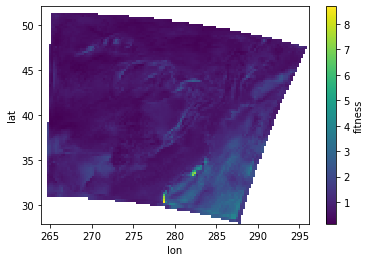

In [13]:
wrfdata['fitness'].plot()

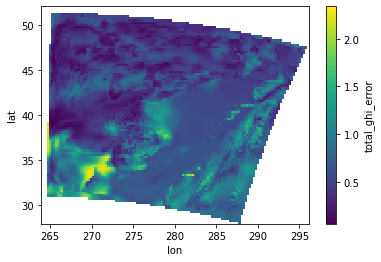

In [14]:
wrfdata.total_ghi_error.plot()

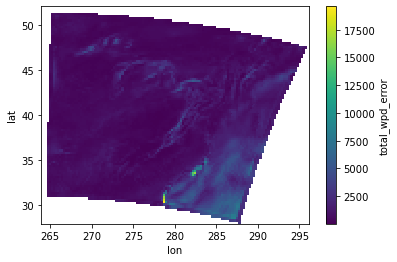

In [15]:
wrfdata.total_wpd_error.plot()

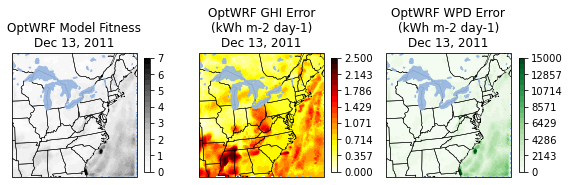

In [16]:
save_fig = True
consistent_max = True
# Create a figure
fig = plt.figure(figsize=(9.5,3))

# Set the GeoAxes to the projection used by WRF
ax_fitness= fig.add_subplot(1,3,1, projection=wrf_cartopy_proj)
ax_ghierr = fig.add_subplot(1,3,2, projection=wrf_cartopy_proj, sharey=ax_fitness)
ax_wpderr = fig.add_subplot(1,3,3, projection=wrf_cartopy_proj, sharey=ax_ghierr)

# Create the filled contour levels
if consistent_max:
    ghierr_cn_levels = np.linspace(0, 2.5, 22)
else:
    ghierr_cn_levels = np.linspace(0, np.amax(wrfdata['total_ghi_error']), 22)
ghierr_cn = ax_ghierr.contourf(to_np(wrfdata.lon), to_np(wrfdata.lat), to_np(wrfdata['total_ghi_error']), 
                               ghierr_cn_levels, transform=ccrs.PlateCarree(), cmap=get_cmap("hot_r"))

if consistent_max:
    wpderr_cn_levels = np.linspace(0, 15000, 22)
else:
    wpderr_cn_levels = np.linspace(0, np.amax(wrfdata['total_wpd_error']), 22)
wpderr_cn = ax_wpderr.contourf(to_np(wrfdata.lon), to_np(wrfdata.lat), to_np(wrfdata['total_wpd_error']), 
                               wpderr_cn_levels, transform=ccrs.PlateCarree(), cmap=get_cmap("Greens"))

if consistent_max:
    fitness_cn_levels = np.linspace(0, 7, 22)
else:
    fitness_cn_levels = np.linspace(0, np.amax(wrfdata['fitness']), 22)
fitness_cn = ax_fitness.contourf(to_np(wrfdata.lon), to_np(wrfdata.lat), to_np(wrfdata['fitness']), 
                               fitness_cn_levels, transform=ccrs.PlateCarree(), cmap=get_cmap("Greys"))

# Format the axes
time_string_f = wrfdata.Time[0].dt.strftime('%b %d, %Y')
format_cnplot_axis(ax_ghierr, ghierr_cn, proj_bounds,
                   title_str=f'OptWRF GHI Error\n(kWh m-2 day-1)\n{time_string_f.values}')
format_cnplot_axis(ax_wpderr, wpderr_cn, proj_bounds,
                   title_str=f'OptWRF WPD Error\n(kWh m-2 day-1)\n{time_string_f.values}')
format_cnplot_axis(ax_fitness, fitness_cn, proj_bounds,
                   title_str=f'OptWRF Model Fitness\n{time_string_f.values}')

if save_fig:
    fig_path = f'/Users/jsward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/figures/daily_GHI_WPD_Err_Fitness_plot_{datestr}_{paramstr}'
    plt.savefig(fig_path + '.pdf', transparent=True, bbox_inches='tight')
                             
plt.show()

## OLD Plotting functions start here --------------------------------------------------------------------